In [1]:
from IPython.display import clear_output

In [2]:
!echo "Downloading 101_Object_Categories for image notebooks"

!curl -L -o 101_ObjectCategories.zip --progress-bar https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip?download=1
!unzip 101_ObjectCategories.zip
!mv caltech-101/101_ObjectCategories.tar.gz ./101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls

clear_output()

In [3]:
import random

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Subset, DataLoader, Dataset

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [4]:
to_tensor = transforms.ToTensor()

class GrayScaleToColorTransform:

    def __call__(self, img):
        return to_tensor(img.convert('L')), to_tensor(img)

In [5]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    GrayScaleToColorTransform()
])

image_dataset = torchvision.datasets.ImageFolder(root='101_ObjectCategories', transform=transform)

In [6]:
(gs_img, rgb_img), _ = image_dataset[0]  # _ is the image class which we don't need for this assignment

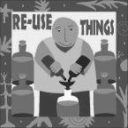

In [7]:
transforms.functional.to_pil_image(gs_img)

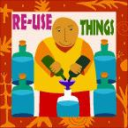

In [8]:
transforms.functional.to_pil_image(rgb_img)

In [9]:
print(len(image_dataset))

9144


# Tasks:

1. Build a custo [AutoEncoder] NN model. The input to the model is the Gray Scale Image and it's output should be colored image.
2. Split the data into training and validation splits (80%, 20%). Train the model on training data.
3. After training, show final loss value as well as draw a plot to show how loss dropped during training (both train and val loss).
4. Manually show the model's performance. Pick 3 random grayscale image, and RGB img pairs from the **val dataset** and for each of the grayscale image, show the grayscale img, the RGB image, and the model output image.

In [10]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

# def trans_conv_block(in_channels, out_channels):
#     return nn.Sequential(
#         nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, padding=0, stride=2),
#         nn.BatchNorm2d(out_channels),
#         nn.ReLU(inplace=True)
#     )

In [11]:
class encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block1 = conv_block(in_channels, out_channels)
        self.conv_block2 = conv_block(out_channels, out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x1 = self.conv_block1(x)
        x2 = self.conv_block2(x1)
        x3 = self.maxpool(x2)
        return x3, x2

In [12]:
class decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block1 = conv_block(in_channels, in_channels)
        self.trans_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, padding=0, stride=2)
        self.conv_block2 = conv_block(in_channels, out_channels)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x, enc, dropout=False):
        x = self.conv_block1(x)
        if dropout: x = self.dropout(x)
        x = self.trans_conv(x)
        x = torch.cat([x, enc], dim=1)
        x = self.conv_block2(x)
        return x

In [13]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = encoder(1, 64)
        self.enc2 = encoder(64, 128)
        self.enc3 = encoder(128, 256)
        self.enc4 = encoder(256, 512)

        self.bottleneck = conv_block(512, 1024)

        self.dec1 = decoder(1024, 512)
        self.dec2 = decoder(512, 256)
        self.dec3 = decoder(256, 128)
        self.dec4 = decoder(128, 64)

        self.final = nn.Conv2d(64, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x, enc1 = self.enc1(x)
        x, enc2 = self.enc2(x)
        x, enc3 = self.enc3(x)
        x, enc4 = self.enc4(x)

        x = self.bottleneck(x)

        x = self.dec1(x, enc4, dropout=True)
        x = self.dec2(x, enc3, dropout=True)
        x = self.dec3(x, enc2, dropout=True)
        x = self.dec4(x, enc1)

        x = self.final(x)

        return x

In [14]:
train_set, val_set = torch.utils.data.random_split(image_dataset, [0.8, 0.2])

In [15]:
# class MyDataset(Dataset):
#     def __init__(self, root='.', train=True):
#         if train:
#             self.transforms = transforms.Compose([
#                 transforms.Resize((256, 256)),
#                 transforms.RandomHorizontalFlip(),
#                 transforms.RandomCrop(256),
#                 GrayScaleToColorTransform(),
#                 transforms.ToTensor(),
#             ])
#             self.dataset = torchvision.datasets.ImageFolder(root=root, transform=self.transforms)
#             self.dataset, _ = torch.utils.data.random_split(self.dataset, [0.8, 0.2])

#         else:
#             self.transforms = transforms.Compose([
#                 transforms.Resize((256, 256)),
#                 GrayScaleToColorTransform(),
#                 transforms.ToTensor(),
#             ])
#             self.dataset = torchvision.datasets.ImageFolder(root=root, transform=self.transforms)
#             _, self.dataset = torch.utils.data.random_split(self.dataset, [0.8, 0.2])

#         self.train = train

#     def __getitem__(self, idx):
#         return self.dataset[idx]

#     def __len__(self):
#         return len(self.dataset)

In [16]:
# train_set = MyDataset(root='101_ObjectCategories', train=True)
# val_set = MyDataset(root='101_ObjectCategories', train=False)

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [19]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)

lr=5e-4
weight_decay=1e-2
num_epochs=5
criterion=nn.MSELoss()

optimizer=optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler=optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.925)


In [20]:
# Defining the training function
def train(model, epochs, optimizer, criterion, device, scheduler=None):
    # Lists to keep track of the losses for plotting later
    val_losses = []
    train_losses = []

    # Iterating over epochs
    for epoch_num in range(epochs):
        model.train() # Sets the model in training mode

        epoch_losses = 0

        # Looping over batches for each epoch
        for (batch_x, batch_y), _ in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            batch_y_preds = model(batch_x) # Forward pass

            loss = criterion(batch_y_preds, batch_y) # Calculating the loss per batch

            optimizer.zero_grad()
            loss.backward() # Backwards pass
            optimizer.step() # Updating parameters

            epoch_losses += (len(batch_y)*loss.item()) # Keeping track of the losses per batch

        epoch_loss = epoch_losses/len(train_loader.dataset)
        train_losses.append(epoch_loss) # Keeping training track of the loss per epoch

        model.eval() # Sets the model in evaluation mode for validation
        correctly_labelled = 0
        with torch.no_grad(): # Disables gradient calculation
            val_epoch_losses = 0
            for (val_batch_x, val_batch_y), _ in val_loader:
                val_batch_x = val_batch_x.to(device)
                val_batch_y = val_batch_y.to(device)

                val_batch_y_preds = model(val_batch_x) # Predictions
                val_loss = criterion(val_batch_y_preds, val_batch_y)
                val_epoch_losses += (len(val_batch_y)*val_loss.item())

            val_epoch_loss = val_epoch_losses/len(val_loader.dataset)
            val_losses.append(val_epoch_loss) # Tracking epoch validation loss

        if scheduler:
            scheduler.step() # Updating the learning rate scheduler if one was provided
            print(f'Epoch: {epoch_num+1}/{epochs}, learning_rate={optimizer.param_groups[0]["lr"]:.6f} train_loss={epoch_loss:.4f}, val_loss={val_epoch_loss:.4f}.')
        else:
            print(f'Epoch: {epoch_num+1}/{epochs}, train_loss={epoch_loss:.4f}, val_loss={val_epoch_loss:.4f}.')
    print('Training Done')
    return train_losses, val_losses # Returns the losses in order to keep track of them

In [21]:
# Function to plot the training losses and validation losses vs epochs. This will help identify overfitting and model performance
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='train loss')
    plt.plot(val_losses, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Cross Entropy)')
    plt.legend()
    plt.show()

In [22]:
%%time

# Training the model
train_losses = []
val_losses = []

cycle_train_losses, cycle_val_losses = train(model, num_epochs, optimizer, criterion, device, scheduler=scheduler)

train_losses += cycle_train_losses
val_losses += cycle_val_losses

Epoch: 1/5, learning_rate=0.000463 train_loss=0.0195, val_loss=0.0104.
Epoch: 2/5, learning_rate=0.000428 train_loss=0.0101, val_loss=0.0143.
Epoch: 3/5, learning_rate=0.000396 train_loss=0.0095, val_loss=0.0091.
Epoch: 4/5, learning_rate=0.000366 train_loss=0.0096, val_loss=0.0090.
Epoch: 5/5, learning_rate=0.000339 train_loss=0.0090, val_loss=0.0095.
Training Done
CPU times: user 8min 45s, sys: 3.96 s, total: 8min 49s
Wall time: 8min 53s


In [27]:
%%time

cycle_train_losses, cycle_val_losses = train(model, num_epochs, optimizer, criterion, device, scheduler=scheduler)

train_losses += cycle_train_losses
val_losses += cycle_val_losses

Epoch: 1/5, learning_rate=0.000313 train_loss=0.0092, val_loss=0.0078.
Epoch: 2/5, learning_rate=0.000290 train_loss=0.0086, val_loss=0.0095.
Epoch: 3/5, learning_rate=0.000268 train_loss=0.0086, val_loss=0.0085.
Epoch: 4/5, learning_rate=0.000248 train_loss=0.0087, val_loss=0.0088.
Epoch: 5/5, learning_rate=0.000229 train_loss=0.0086, val_loss=0.0082.
Training Done
CPU times: user 8min 28s, sys: 2.76 s, total: 8min 31s
Wall time: 8min 32s


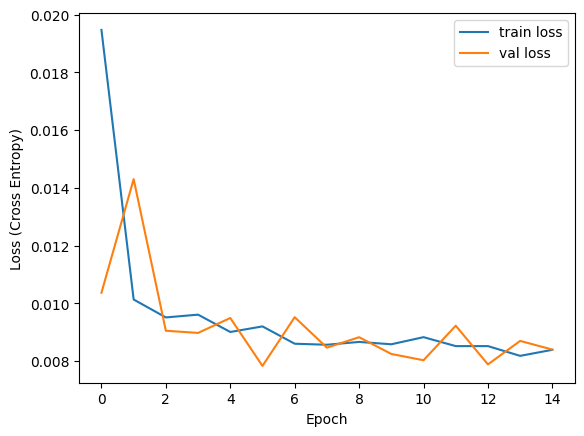

In [31]:
plot_losses(train_losses, val_losses)

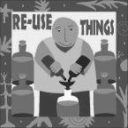

In [24]:
(gs_img, rgb_img), _ = image_dataset[0]

transforms.functional.to_pil_image(gs_img)

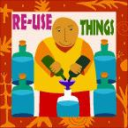

In [25]:
transforms.functional.to_pil_image(rgb_img)

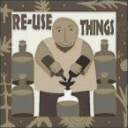

In [32]:
predicted = model(gs_img.unsqueeze(0).to(device))
transforms.functional.to_pil_image(predicted[0])

In [30]:
%%time

cycle_train_losses, cycle_val_losses = train(model, num_epochs, optimizer, criterion, device, scheduler=scheduler)

train_losses += cycle_train_losses
val_losses += cycle_val_losses

Epoch: 1/5, learning_rate=0.000212 train_loss=0.0088, val_loss=0.0080.
Epoch: 2/5, learning_rate=0.000196 train_loss=0.0085, val_loss=0.0092.
Epoch: 3/5, learning_rate=0.000181 train_loss=0.0085, val_loss=0.0079.
Epoch: 4/5, learning_rate=0.000168 train_loss=0.0082, val_loss=0.0087.
Epoch: 5/5, learning_rate=0.000155 train_loss=0.0084, val_loss=0.0084.
Training Done
CPU times: user 8min 21s, sys: 2.46 s, total: 8min 24s
Wall time: 8min 25s
